# =================================================================  Il s'agit d'un premier jet de la préparation des données et du test de modèles. Mais tout ceci va être modifié pour essayer d'améliorer tout ça.  =================================================================

# Préparation du jeu de données

## Nettoyage du jeu de données

## Feature engineering

### Variables temporelles

Création d'une variable de début de tempête et de l'âge de la tempête en cours

In [47]:
df['start_date'] = df.groupby('SID')['ISO_TIME'].transform('min')
df['age_hours'] = (df['ISO_TIME'] - df['start_date']).dt.total_seconds() / 3600

In [48]:
variables_temporelles = ["start_date","age_hours","SEASON","ISO_TIME","YEAR","MONTH","start_month"]

In [49]:
variable_cible = 'TD9636_STAGE' 

In [50]:
df = df.dropna(subset=[variable_cible])

In [51]:
df_temporel = df[variables_temporelles + [variable_cible]].copy()

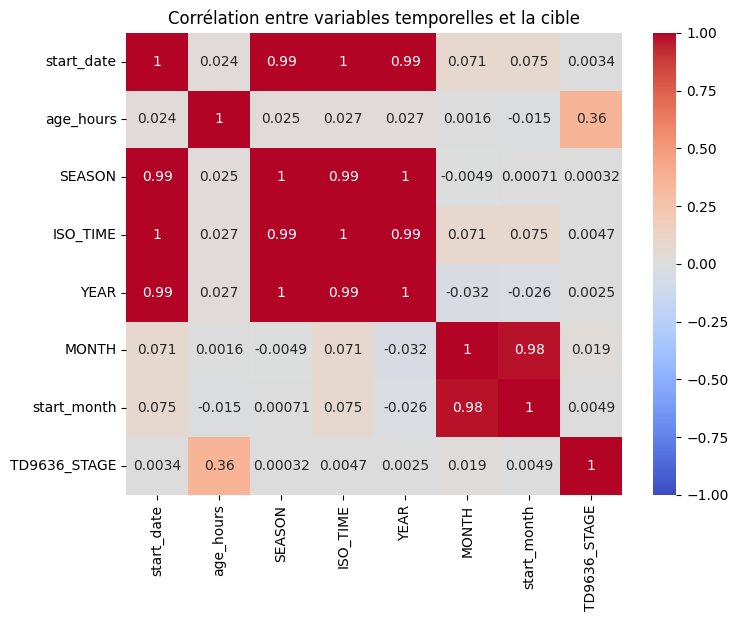

In [52]:
df_temporel[variable_cible] = pd.to_numeric(df_temporel[variable_cible], errors='coerce')
corr_mat = df_temporel.corr(method='pearson')
plt.figure(figsize=(8, 6))
sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Corrélation entre variables temporelles et la cible")
plt.show()

ON remarque que la seule variable temporelle qui semble être correllée avec la variable cible est la variable age_hours que nous avons créé

Nous allons essayer de confirmer cela via un random forest

In [53]:
df_temporel = df_temporel.drop(columns=['start_date', 'ISO_TIME'])
variables_temporelles = ["age_hours","SEASON","YEAR","MONTH","start_month"]

       feature  importance
0    age_hours    0.637232
4  start_month    0.094307
3        MONTH    0.091408
1       SEASON    0.088918
2         YEAR    0.088135


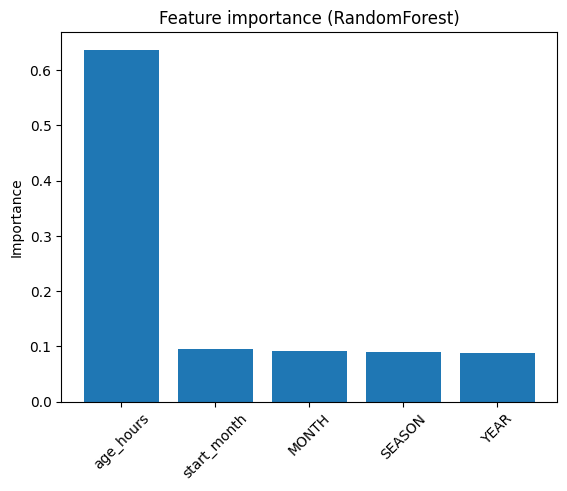

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_temporel[variable_cible] = le.fit_transform(df_temporel[variable_cible])


X = df_temporel[variables_temporelles]
y = df_temporel[variable_cible]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importance_variables_temporelles = rf.feature_importances_
df_importance_variables_temporelles = pd.DataFrame({
    'feature': variables_temporelles,
    'importance': importance_variables_temporelles
}).sort_values('importance', ascending=False)

print(df_importance_variables_temporelles)

plt.bar(df_importance_variables_temporelles['feature'], df_importance_variables_temporelles['importance'])
plt.title("Feature importance (RandomForest)")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()

Le Random forest nous confirme bien l'importance d'une seule variable qui est celle de l'âge de la tempête en heures. Nous allons donc supprimmer les autres

In [55]:
variables_to_drop = ["ISO_TIME","start_date","SEASON","YEAR","MONTH","start_month"]
df = df.drop(columns = variables_to_drop)

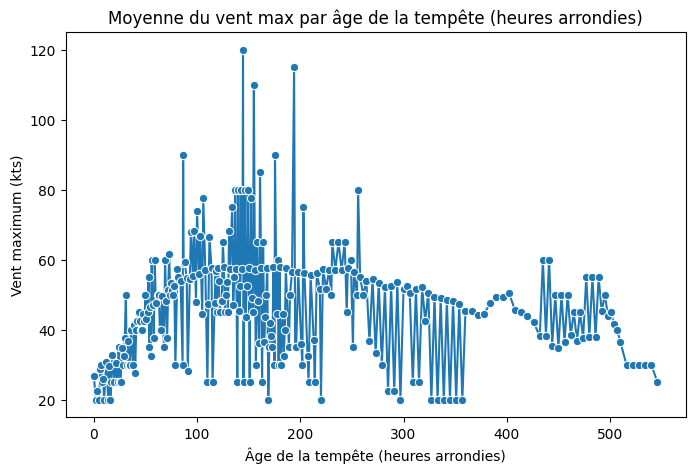

In [56]:
df_plot = df.groupby('age_hours')['WMO_WIND'].mean().reset_index()

plt.figure(figsize=(8,5))
sns.lineplot(data=df_plot, x='age_hours', y='WMO_WIND', marker='o')
plt.title("Moyenne du vent max par âge de la tempête (heures arrondies)")
plt.xlabel("Âge de la tempête (heures arrondies)")
plt.ylabel("Vent maximum (kts)")
plt.show()

### Mutualisation des variables de localisation en une seule variable

Nous remarquons que certaines variables sont les mêmes mais nommées par zones. Par exemple nous pouvons nous séparer de toutes les variables de latitude et longitude en dehors des variables globales, car cela fait doublon.

In [57]:
df[["TD9636_LAT","TD9636_LON","LAT","LON"]].sample(20)

,TD9636_LAT,TD9636_LON,LAT,LON
36093,15.3,-146.2,15.2,-146.2
63234,16.8,109.8,16.6,109.8
2282,8.9,-111.0,8.9,-111.0
48824,-12.4,165.1,-12.5,165.1
1242,-28.4,62.9,-28.4,62.9
2738,22.0,112.4,22.0,112.2
54060,13.8,116.6,13.7,116.8
36826,29.1,132.3,29.0,132.4
42311,-11.2,95.5,-11.5,96.3
63220,14.9,117.6,14.9,117.8


Les TD_9636 LAT et LON ne seront pas gardées car elles ont des valeurs manquantes

In [58]:
df = df.drop(columns=[col for col in df.columns if col.endswith('_LON') or col.endswith('_LAT')])
print(f"Il reste {df.shape[1]} variables")

Il reste 143 variables


### Variable WMO_WIND

Il s'agit de la vitesse maximale du vent soutenu enregistrée par l'agence météorologique officielle (WMO). Le problème est que les périodes d'échantillonage sont différentes en fonctiond es zones (1min ou 3 min ou 10min). Donc la variable doit être corrigée pour que les différentes zones soient comparables. Pour cela nous avons effectué des recherches sur le sujet, et nous sommes tombé sur un article scientifique qui explique comment corriger ce problème en appliquant des ratios à la variable en fonciton de la localisation de la tempête et en fonction de la durée d'échantillonage. \
Voici le lien :  \
https://www.systemsengineeringaustralia.com.au/download/WMO_TC_Wind_Averaging_27_Aug_2010.pdf

Il s'agit de la table 1.1

In [59]:
# Définition d'une fonction pour déterminer la période d'échantillonnage selon l'agence
def determine_averaging_period(agency):
    mapping = {
        'hurdat_atl': '1min',
        'hurdat_epa': '1min',
        'cphc': '1min',
        'tokyo': '10min',
        'newdelhi': '3min',
        'reunion': '10min',
        'bom': '10min',
        'nadi': '10min',
        'wellington': '10min'
    }
    return mapping.get(agency, '10min')  # Valeur par défaut à 10 min si non précisé

# Fonction pour appliquer les ratios de conversion selon la localisation et la durée d'échantillonnage
def apply_wind_conversion(row):
    dist = row['DIST2LAND']
    wind_speed = row['WMO_WIND']
    agency = row['WMO_AGENCY']

    # Déterminer la durée d'échantillonnage
    avg_period = determine_averaging_period(agency)

    # Déterminer la catégorie d'exposition en fonction de DIST2LAND
    if dist > 20:
        exposure_ratios = {'1min': 1, '3min': 1, '10min': 1.05}
    elif dist <= 1:
        exposure_ratios = {'1min': 1, '3min': 1.10, '10min': 1.16}
    else:
        exposure_ratios = {'1min': 1, '3min': 1.05, '10min': 1.11}

    return wind_speed * exposure_ratios[avg_period]


df['WMO_WIND_ADJUSTED'] = df.apply(apply_wind_conversion, axis=1)

Comme dit juste avant les ratios sont attribués par rapport à la durée d'échantillonage et par rapport à la localisation (c'est à dire si la tempête est en mer ou proche de la côte. Pour savoir cela nous pouvons nous appuyer sur la variable DIST2LAND).

### Les différentes mesures de vitesse de vent

Nous essayons de comprendre la relation entre les différentes variables, notamment la différence entre WMO_WIND et TD9636_WIND

In [60]:
df[["TOKYO_WIND","USA_WIND","HKO_WIND","CMA_WIND","NEUMANN_WIND","TD9636_WIND","WMO_WIND","SID","NAME","BASIN","SUBBASIN","USA_WIND"]].sample(5)

,TOKYO_WIND,USA_WIND,HKO_WIND,CMA_WIND,NEUMANN_WIND,TD9636_WIND,WMO_WIND,SID,NAME,BASIN,SUBBASIN,USA_WIND
46367,<NA>,<NA>,<NA>,<NA>,<NA>,25,NaN,1986302N05178,HERBERT,WP,MM,<NA>
1068,<NA>,50,<NA>,<NA>,50,<NA>,NaN,1980056S15059,KOLIA,SI,MM,50
16686,<NA>,25,30,31,<NA>,<NA>,NaN,1982220N08154,DOT,WP,MM,25
27395,<NA>,25,<NA>,<NA>,25,30,20.0,1984094S10080,KAMISY,SI,MM,25
14825,<NA>,33,<NA>,<NA>,23,31,NaN,1982095S11138,DOMINIC,SP,EA,33


WMO_WIND = mesure officielle (selon l’agence WMO correspondante), mais la période de moyennage varie selon la région (1, 3 ou 10 minutes), ce qui peut compliquer la comparaison directe entre différentes zones. \
TD9636_WIND = estimation (subjective) de la vitesse maximale instantanée, homogénéisée sur une période de 1 minute, mais avec moins de garanties « officielles » et plus d’incertitudes (d’où la mise en garde sur l’interprétation).

Idées : On peut se servir de WMO_WIND_ADJUSTED en premier que l'on ajuste avec les ratios trouvés, et on peut compléter des NaN Par des valeurs de TD9636_WIND quand il y en a.
Le reste des NaN peuvent être complétés par les valeurs de avant et après dans la chronologie de la tempête

In [61]:
# Exécution de l'idée
# Remplaçage des premières valeurs manquantes par les valeurs de TD936_WIND 
df['WMO_WIND_ADJUSTED_COMPLETED'] = df['WMO_WIND_ADJUSTED'].fillna(df['TD9636_WIND'])

In [62]:
#Remplaçage des dernières valeurs manquantes par les moyennes de la première valeur non nulle précédente et suivante.
df['WMO_WIND_ADJUSTED_COMPLETED'] = pd.to_numeric(
    df['WMO_WIND_ADJUSTED_COMPLETED'], 
    errors='coerce'
)

# Amélioration : quand plusieurs valeurs NaN d'affilées faire montée ou descente progressive des valeurs.

In [63]:
df = df.sort_values(by=['SID', 'age_hours'])

df['forward'] = df.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].ffill()
df['backward'] = df.groupby('SID')['WMO_WIND_ADJUSTED_COMPLETED'].bfill()

def fill_value(row):
    original = row['WMO_WIND_ADJUSTED_COMPLETED']
    if not pd.isna(original):
        return original
    
    f = row['forward']
    b = row['backward']
    
    if pd.isna(f) and pd.isna(b):
        return np.nan    
    if pd.isna(b):
        return f    
    if pd.isna(f):
        return b    
    return (f + b) / 2

df['WMO_WIND_ADJUSTED_COMPLETED'] = df.apply(fill_value, axis=1)
df.drop(columns=['forward', 'backward'], inplace=True)

Nous décidons de ne garder que WMO_WIND_ADUJUSTED_COMPLETED parmis les variables de vent. En effet, il s'agit d'une amélioration des variables WMO_WIND_ADJUSTED, WMO_WIND et TD9636_WIND. De plus les autres variables de vent correspodent soit à une autre zone que celle de la tempête, soit à la zone de la tempête, mais ce qui fais doublon.

In [64]:
df = df.drop(columns=["WMO_WIND_ADJUSTED","WMO_WIND","TD9636_WIND","USA_WIND","TOKYO_WIND","CMA_WIND","HKO_WIND",
                     "NEUMANN_WIND"])

### Suppression des variables avec une trop grosse proportion de NA 

Nous considérons qu'à partir d'un certain seuil, les NA deviennent compliqués à remplacer et le modèle aura du mal à utiliser les variables dans ses prédictions.

In [65]:
threshold = 0.5 
nan_ratio = df.isna().mean()
df = df.loc[:, nan_ratio < threshold]
print(f"Il reste {df.shape[1]} variables")

Il reste 19 variables


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48343 entries, 1 to 67410
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SID                          48343 non-null  object 
 1   NUMBER                       48343 non-null  object 
 2   BASIN                        48343 non-null  object 
 3   SUBBASIN                     48343 non-null  object 
 4   NAME                         48343 non-null  object 
 5   NATURE                       48343 non-null  object 
 6   LAT                          48343 non-null  float64
 7   LON                          48343 non-null  float64
 8   TRACK_TYPE                   48343 non-null  object 
 9   DIST2LAND                    48343 non-null  int64  
 10  LANDFALL                     47893 non-null  object 
 11  IFLAG                        48343 non-null  object 
 12  USA_ATCF_ID                  41691 non-null  object 
 13  USA_SSHS             

In [67]:
df = df.drop(columns=["SID","NUMBER","SUBBASIN","NAME","USA_ATCF_ID"])

In [68]:
df = df.dropna()

In [69]:
df['STORM_SPEED'] = pd.to_numeric(df['STORM_SPEED'], errors='coerce').astype('Int64')

for col in ['BASIN', 'NATURE', 'TRACK_TYPE', 'LANDFALL', 'IFLAG', 'STORM_DIR']:
    df[col] = df[col].astype('category')

# Création de modèles

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [71]:
df['TD9636_STAGE'] = df['TD9636_STAGE'].astype('category').cat.codes

### Test toutes les colonnes restantes

In [72]:
X = df.drop(columns=['TD9636_STAGE'], errors='ignore').copy()
y = df['TD9636_STAGE'].copy()

In [73]:
def evaluate_model(X_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
    )
    model = XGBClassifier(
        n_estimators=100,
        use_label_encoder=False,
        eval_metric='mlogloss',
        enable_categorical=True,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    acc = accuracy_score(y_test, y_pred)
    return f1, acc



f1, acc = evaluate_model(X, y)

print("=== Résultats premier modèle ===")
print(f"F1-score (macro) : {f1:.3f}")
print(f"Accuracy        : {acc:.3f}")

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Résultats premier modèle ===
F1-score (macro) : 0.849
Accuracy        : 0.907


### Test avec toutes les combinaisons des colonnes du dataframe final avec un modèle XGBoost pour voir

Cette cellule prendrait environ 8 heures à s'éxécuter si on la faisai tourner avec un i7 11 ème gen de 40 go de RAM

In [74]:
# from itertools import combinations



# def all_subsets_feature_selection(df, target_col, max_results=10):
#     # 1) Récupérer la liste de toutes les colonnes, hors cible
#     all_features = [c for c in df.columns if c != target_col]
    
#     results = []
    
#     for r in range(1, len(all_features) + 1):
#         for subset in combinations(all_features, r):
#             subset = list(subset)  # pour être sûr d'avoir une liste
#             print(subset)
#             X = df[subset].copy()
#             y = df[target_col].copy()
            
#             # On supprime les NaN, par exemple
#             data_no_na = pd.concat([X, y], axis=1).dropna()
#             X_clean = data_no_na[subset]
#             y_clean = data_no_na[target_col]
            
#             if len(X_clean) == 0:
#                 continue
            
#             f1, acc = evaluate_model(X_clean, y_clean)
            
#             results.append({
#                 'features': subset,
#                 'f1_score': f1,
#                 'accuracy': acc
#             })
    
#     results_df = pd.DataFrame(results)
#     results_df = results_df.sort_values(by=['f1_score', 'accuracy'], ascending=False)
#     return results_df.head(max_results)


# # Exemple d'utilisation
# best_subsets = all_subsets_feature_selection(df, 'TD9636_STAGE', max_results=10)
# print(best_subsets)

### Méthode wrapper incrémentale

In [75]:
best_features = []
remaining_features = list(X.columns)
best_score = 0.0

while True:
    improved = False
    best_candidate = None
    
    for candidate in remaining_features:
        
        current_subset = best_features + [candidate]
        f1, acc = evaluate_model(X[current_subset], y)  
        
        if acc > best_score:
            best_score = acc
            best_candidate = candidate
            improved = True
    
    if improved:
        best_features.append(best_candidate)
        remaining_features.remove(best_candidate)
    else:
        break

print("Meilleur sous-ensemble : ", best_features)

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:57] WAR

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:29] WAR

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:11] WAR

Meilleur sous-ensemble :  ['WMO_WIND_ADJUSTED_COMPLETED', 'NATURE', 'USA_SSHS', 'age_hours', 'LON', 'LAT', 'STORM_SPEED']


On test le modèle

In [76]:
X = df[best_features].copy()
y = df['TD9636_STAGE'].copy()

In [77]:
f1, acc = evaluate_model(X, y)

print("=== Résultats premier modèle ===")
print(f"F1-score (macro) : {f1:.3f}")
print(f"Accuracy        : {acc:.3f}")

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Résultats premier modèle ===
F1-score (macro) : 0.870
Accuracy        : 0.926


### Optimisation des hyper paramètres par méthode GridSearch

In [78]:
# from sklearn.metrics import accuracy_score, make_scorer

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )



# model = XGBClassifier(
#         n_estimators=100,
#         use_label_encoder=False,
#         eval_metric='mlogloss',
#         enable_categorical=True,
#         random_state=42
#     )


# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0]
# }


# acc_scorer = make_scorer(accuracy_score)

# from sklearn.model_selection import GridSearchCV

# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring=acc_scorer,  
#     cv=5,                
#     verbose=1,           
#     n_jobs=-1)          

# grid_search.fit(X_train, y_train)

# print("Meilleurs hyperparamètres :", grid_search.best_params_)
# print("Meilleur score (Accuracy CV) :", grid_search.best_score_)
# best_model = grid_search.best_estimator_

# from sklearn.metrics import classification_report

# y_pred_test = best_model.predict(X_test)
# print("Accuracy sur le test set :", accuracy_score(y_test, y_pred_test))
# print(classification_report(y_test, y_pred_test))

# Modèle final avec sélection des variables par méthode wrapper et avec hyper paramètres optimisés

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )


best_params = {
    'colsample_bytree': 1.0,
    'learning_rate': 0.2,
    'max_depth': 7,
    'n_estimators': 200,
    'subsample': 0.8
}

final_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='mlogloss',
    enable_categorical=True,  
    **best_params
)


final_model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, classification_report

y_pred = final_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print(classification_report(y_test, y_pred))

C:\DSTI\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:19:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9358001265022138
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       631
           1       0.95      0.95      0.95      3064
           2       0.91      0.94      0.93      3412
           3       0.74      0.53      0.62       148
           4       0.95      0.93      0.94      2119
           5       1.00      0.79      0.88        63
           6       0.95      0.86      0.90        49

    accuracy                           0.94      9486
   macro avg       0.93      0.86      0.89      9486
weighted avg       0.94      0.94      0.94      9486



In [80]:
df_comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

In [81]:
df_comparison.sample(20)

,Actual,Predicted
20720,4,4
33074,1,1
49035,4,1
17619,0,1
40520,1,1
1613,1,2
965,4,4
15044,0,0
16958,2,2
58274,4,2


In [88]:
df['TD9636_STAGE'].value_counts(normalize=True) * 100

TD9636_STAGE
2    35.965504
1    32.296631
4    22.337958
0     6.650361
3     1.564543
5     0.668410
6     0.516594
Name: proportion, dtype: float64

In [89]:
from sklearn.metrics import confusion_matrix

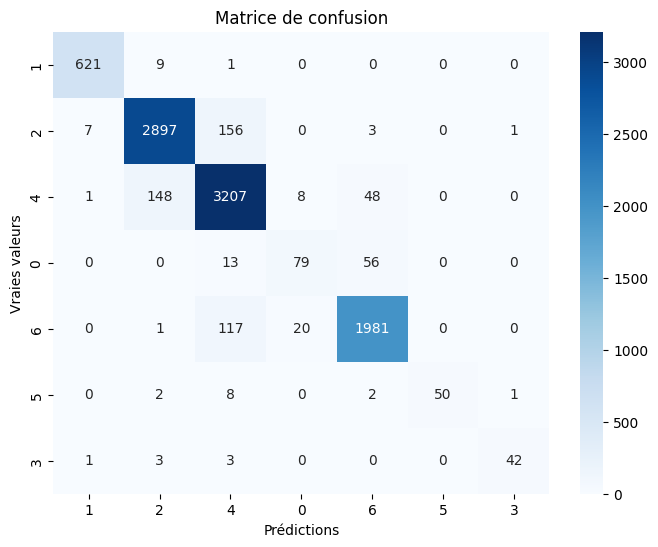

In [91]:
y_pred = final_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=df['TD9636_STAGE'].unique(), yticklabels=df['TD9636_STAGE'].unique())
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de confusion")
plt.show()

Analyse des performances du modèle : 
- bon F1 score, bonne accuracy. \
Par contre : 
- Classe 3 mal prédite 
- Classe 6 a un recal élevé pour une classe rare

# Il faut bosser sur le modèle pour qu'il prédise mieux les classes minoritaires